In [ ]:
# ===== CONFIGURATION =====
MARKET_ID = "903216"  # Change this to your market ID

# Training hyperparameters
EPOCHS = 30
PATIENCE = 5
BATCH_SIZE = 256
LEARNING_RATE = 1e-4  # LOWERED from 3e-4
WEIGHT_DECAY = 5e-2   # INCREASED from 1e-2
PRECISION_TARGET = 0.60  # Target precision for threshold calibration

# Model architecture
D_MODEL = 64          # REDUCED from 128
DROPOUT = 0.2         # INCREASED from 0.1

# Data options
USE_SCALING = True  # Apply per-market StandardScaler

# Early stopping: use per-market validation (not pooled)
USE_PER_MARKET_EARLY_STOPPING = True

In [2]:
import sys
from pathlib import Path
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import average_precision_score, roc_auc_score, confusion_matrix

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {'cuda' if torch.cuda.is_available() else 'cpu'}")

PyTorch version: 2.9.1+cu128
Device: cuda


## Load Data

In [4]:
def load_move_dir(move_dir: Path):
    """Load X_train, y_train, X_val, y_val, X_test, y_test from a move directory."""
    X_train = np.load(move_dir / "X_train.npy")
    y_train = np.load(move_dir / "y_train.npy")
    X_val   = np.load(move_dir / "X_val.npy")
    y_val   = np.load(move_dir / "y_val.npy")
    X_test  = np.load(move_dir / "X_test.npy")
    y_test  = np.load(move_dir / "y_test.npy")
    return {
        "X_train": X_train, "y_train": y_train,
        "X_val": X_val,     "y_val": y_val,
        "X_test": X_test,   "y_test": y_test,
    }

def scale_per_market(ds):
    """Fit scaler on TRAIN only, apply to train/val/test."""
    scaler = StandardScaler()
    Xtr = ds["X_train"]
    scaler.fit(Xtr.reshape(-1, Xtr.shape[-1]))

    def tx(X):
        X2 = scaler.transform(X.reshape(-1, X.shape[-1]))
        return X2.reshape(X.shape).astype(np.float32)

    out = dict(ds)
    out["X_train"] = tx(out["X_train"])
    out["X_val"]   = tx(out["X_val"])
    out["X_test"]  = tx(out["X_test"])
    return out

# Load data
data_root = Path("../IEOR4212/exploration/processed") / MARKET_ID / "move"

if not data_root.exists():
    raise FileNotFoundError(f"Data directory not found: {data_root}")

print(f"Loading data from: {data_root}")
dataset = load_move_dir(data_root)

if USE_SCALING:
    print("Applying per-market StandardScaler...")
    dataset = scale_per_market(dataset)

Xtr, ytr = dataset["X_train"], dataset["y_train"]
Xva, yva = dataset["X_val"], dataset["y_val"]
Xte, yte = dataset["X_test"], dataset["y_test"]

print(f"\nDataset shapes:")
print(f"  Train: X={Xtr.shape}, y={ytr.shape}")
print(f"  Val:   X={Xva.shape}, y={yva.shape}")
print(f"  Test:  X={Xte.shape}, y={yte.shape}")

print(f"\nClass distribution (Train):")
unique, counts = np.unique(ytr, return_counts=True)
for u, c in zip(unique, counts):
    print(f"  Class {int(u)}: {c:6d} ({100*c/len(ytr):.1f}%)")

print(f"\nClass distribution (Val):")
unique, counts = np.unique(yva, return_counts=True)
for u, c in zip(unique, counts):
    print(f"  Class {int(u)}: {c:6d} ({100*c/len(yva):.1f}%)")

print(f"\nClass distribution (Test):")
unique, counts = np.unique(yte, return_counts=True)
for u, c in zip(unique, counts):
    print(f"  Class {int(u)}: {c:6d} ({100*c/len(yte):.1f}%)")

Loading data from: ../IEOR4212/exploration/processed/903216/move
Applying per-market StandardScaler...

Dataset shapes:
  Train: X=(13656, 120, 25), y=(13656,)
  Val:   X=(2880, 120, 25), y=(2880,)
  Test:  X=(2881, 120, 25), y=(2881,)

Class distribution (Train):
  Class 0:  12951 (94.8%)
  Class 1:    705 (5.2%)

Class distribution (Val):
  Class 0:   2658 (92.3%)
  Class 1:    222 (7.7%)

Class distribution (Test):
  Class 0:   2002 (69.5%)
  Class 1:    879 (30.5%)


## Define Model

In [5]:
from mamba_ssm import Mamba

class MambaMoveClassifier(nn.Module):
    def __init__(self, d_in, d_model=128, dropout=0.1):
        super().__init__()
        self.input_proj = nn.Linear(d_in, d_model)
        self.mamba = Mamba(d_model=d_model, d_state=16, d_conv=4, expand=2)
        self.dropout = nn.Dropout(dropout)
        self.head = nn.Linear(d_model, 1)

    def forward(self, x):
        # x: (B, L, F)
        x = self.input_proj(x)  # (B, L, d_model)
        x = self.mamba(x)       # (B, L, d_model)
        x = x[:, -1, :]         # Take last timestep (B, d_model)
        x = self.dropout(x)
        return self.head(x).squeeze(-1)  # logits (B,)

# Build model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MambaMoveClassifier(d_in=Xtr.shape[-1], d_model=D_MODEL, dropout=DROPOUT).to(device)

print(f"\nModel architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

/home/omfsv2/Work/mlstats/IEOR_project/.venv/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Model architecture:
MambaMoveClassifier(
  (input_proj): Linear(in_features=25, out_features=128, bias=True)
  (mamba): Mamba(
    (in_proj): Linear(in_features=128, out_features=512, bias=False)
    (conv1d): Conv1d(256, 256, kernel_size=(4,), stride=(1,), padding=(3,), groups=256)
    (act): SiLU()
    (x_proj): Linear(in_features=256, out_features=40, bias=False)
    (dt_proj): Linear(in_features=8, out_features=256, bias=True)
    (out_proj): Linear(in_features=256, out_features=128, bias=False)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (head): Linear(in_features=128, out_features=1, bias=True)
)

Total parameters: 119,937


## Prepare Training

In [6]:
# Create data loaders
train_loader = DataLoader(
    TensorDataset(torch.tensor(Xtr, dtype=torch.float32), torch.tensor(ytr, dtype=torch.float32)),
    batch_size=BATCH_SIZE, shuffle=True
)
val_loader = DataLoader(
    TensorDataset(torch.tensor(Xva, dtype=torch.float32), torch.tensor(yva, dtype=torch.float32)),
    batch_size=BATCH_SIZE, shuffle=False
)
test_loader = DataLoader(
    TensorDataset(torch.tensor(Xte, dtype=torch.float32), torch.tensor(yte, dtype=torch.float32)),
    batch_size=BATCH_SIZE, shuffle=False
)

# Calculate pos_weight for class imbalance
pos = float(np.sum(ytr == 1))
neg = float(np.sum(ytr == 0))
pos_weight = torch.tensor([neg / max(pos, 1.0)], dtype=torch.float32, device=device)

print(f"Class balance:")
print(f"  Positive (Move): {int(pos)} ({100*pos/(pos+neg):.1f}%)")
print(f"  Negative (NoMove): {int(neg)} ({100*neg/(pos+neg):.1f}%)")
print(f"  pos_weight: {pos_weight.item():.3f}")

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

print(f"\nOptimizer: AdamW(lr={LEARNING_RATE}, weight_decay={WEIGHT_DECAY})")
print(f"Loss: BCEWithLogitsLoss(pos_weight={pos_weight.item():.3f})")

Class balance:
  Positive (Move): 705 (5.2%)
  Negative (NoMove): 12951 (94.8%)
  pos_weight: 18.370

Optimizer: AdamW(lr=0.0003, weight_decay=0.01)
Loss: BCEWithLogitsLoss(pos_weight=18.370)


## Training Loop

In [ ]:
@torch.no_grad()
def eval_probs(model, loader, device):
    """Evaluate model and return true labels and predicted probabilities."""
    model.eval()
    ys, ps = [], []
    for xb, yb in loader:
        xb = xb.to(device)
        logits = model(xb)
        probs = torch.sigmoid(logits).detach().cpu().numpy()
        ys.append(yb.numpy())
        ps.append(probs)
    y = np.concatenate(ys).astype(int)
    p = np.concatenate(ps)
    return y, p

@torch.no_grad()
def predict_probs_array(model, X, device, batch_size=256):
    """Predict probabilities for a numpy array."""
    model.eval()
    ps = []
    for i in range(0, len(X), batch_size):
        xb = torch.tensor(X[i:i+batch_size], dtype=torch.float32).to(device)
        logits = model(xb)
        probs = torch.sigmoid(logits).detach().cpu().numpy()
        ps.append(probs)
    return np.concatenate(ps)

def eval_per_market_ap(model, dataset, device):
    """Evaluate per-market AP on validation set."""
    pv = predict_probs_array(model, dataset["X_val"], device, batch_size=BATCH_SIZE)
    yv = dataset["y_val"].astype(int)
    if len(np.unique(yv)) > 1 and np.sum(yv) > 0:
        ap = average_precision_score(yv, pv)
    else:
        ap = float("nan")
    return ap

# For single market, we'll track both pooled and "per-market" (which is same here)
# But this structure will work if you later add multiple markets

# Training loop
best_score = -1.0
best_state = None
no_improvement = 0
history = {"train_loss": [], "val_ap": [], "val_auc": [], "val_ap_market": []}

print(f"\nStarting training for {EPOCHS} epochs (patience={PATIENCE})...")
print(f"Early stopping metric: {'Per-market median AP' if USE_PER_MARKET_EARLY_STOPPING else 'Pooled AP'}")
print("="*80)

for epoch in range(1, EPOCHS + 1):
    # Training
    model.train()
    losses = []
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad(set_to_none=True)
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        losses.append(loss.item())

    # Validation - pooled metrics
    yv, pv = eval_probs(model, val_loader, device)
    val_ap_pooled = average_precision_score(yv, pv)
    val_auc = roc_auc_score(yv, pv) if len(np.unique(yv)) > 1 else float("nan")
    
    # Validation - per-market AP (for single market, same as pooled but extracted separately)
    val_ap_market = eval_per_market_ap(model, dataset, device)
    
    # Choose early stopping metric
    if USE_PER_MARKET_EARLY_STOPPING:
        val_score = val_ap_market  # For single market, this is the market AP
    else:
        val_score = val_ap_pooled

    avg_loss = np.mean(losses)
    history["train_loss"].append(avg_loss)
    history["val_ap"].append(val_ap_pooled)
    history["val_auc"].append(val_auc)
    history["val_ap_market"].append(val_ap_market)

    print(f"Epoch {epoch:02d}/{EPOCHS} | loss={avg_loss:.4f} | val_AP={val_ap_pooled:.4f} | val_AUC={val_auc:.4f} | score={val_score:.4f}", end="")

    # Early stopping
    if val_score > best_score + 1e-4:
        best_score = val_score
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        no_improvement = 0
        print(" ← best")
    else:
        no_improvement += 1
        print()
        if no_improvement >= PATIENCE:
            print(f"\nEarly stopping at epoch {epoch} (no improvement for {PATIENCE} epochs)")
            break

print("="*80)
print(f"✓ Training complete! Best validation score: {best_score:.4f}")


Starting training for 30 epochs (patience=5)...
Epoch 01/30 | loss=1.2031 | val_AP=0.2370 | val_AUC=0.6932 ← best
Epoch 02/30 | loss=1.1025 | val_AP=0.2419 | val_AUC=0.6917 ← best
Epoch 03/30 | loss=0.9707 | val_AP=0.1811 | val_AUC=0.6395
Epoch 04/30 | loss=0.9194 | val_AP=0.1818 | val_AUC=0.6479
Epoch 05/30 | loss=0.8830 | val_AP=0.2052 | val_AUC=0.6553
Epoch 06/30 | loss=0.8400 | val_AP=0.1819 | val_AUC=0.6331
Epoch 07/30 | loss=0.8236 | val_AP=0.2089 | val_AUC=0.6161

Early stopping at epoch 7 (no improvement for 5 epochs)
✓ Training complete! Best validation AP: 0.2419


## Load Best Model and Evaluate

In [8]:
# Load best model
if best_state is not None:
    model.load_state_dict(best_state)
    model.to(device)
    print("✓ Loaded best model from training")

# Test set evaluation
yt, pt = eval_probs(model, test_loader, device)
test_ap = average_precision_score(yt, pt)
test_auc = roc_auc_score(yt, pt) if len(np.unique(yt)) > 1 else float("nan")

print(f"\n{'='*80}")
print(f"TEST SET RESULTS:")
print(f"  Average Precision (AP): {test_ap:.4f}")
print(f"  ROC AUC:                {test_auc:.4f}")
print(f"{'='*80}")

✓ Loaded best model from training

TEST SET RESULTS:
  Average Precision (AP): 0.2899
  ROC AUC:                0.4563


In [ ]:
# Load best model
if best_state is not None:
    model.load_state_dict(best_state)
    model.to(device)
    print("✓ Loaded best model from training\n")

# Per-market detailed analysis
print("="*80)
print("PER-MARKET DIAGNOSTIC (single market in this case)")
print("="*80)

# Validation set analysis
pv_market = predict_probs_array(model, dataset["X_val"], device, batch_size=BATCH_SIZE)
yv_market = dataset["y_val"].astype(int)
ap_val_market = average_precision_score(yv_market, pv_market) if len(np.unique(yv_market)) > 1 else float("nan")
move_rate_val = yv_market.mean()

# Test set analysis
pt_market = predict_probs_array(model, dataset["X_test"], device, batch_size=BATCH_SIZE)
yt_market = dataset["y_test"].astype(int)
ap_test_market = average_precision_score(yt_market, pt_market) if len(np.unique(yt_market)) > 1 else float("nan")
move_rate_test = yt_market.mean()

# Training set for comparison
ptr_market = predict_probs_array(model, dataset["X_train"], device, batch_size=BATCH_SIZE)
ytr_market = dataset["y_train"].astype(int)
ap_train_market = average_precision_score(ytr_market, ptr_market) if len(np.unique(ytr_market)) > 1 else float("nan")
move_rate_train = ytr_market.mean()

print(f"\nMarket: {MARKET_ID}")
print(f"{'Split':<8s} | {'AP':>6s} | {'Move%':>6s} | {'n_samples':>10s}")
print("-"*40)
print(f"{'Train':<8s} | {ap_train_market:6.3f} | {100*move_rate_train:6.1f} | {len(ytr_market):10d}")
print(f"{'Val':<8s} | {ap_val_market:6.3f} | {100*move_rate_val:6.1f} | {len(yv_market):10d}")
print(f"{'Test':<8s} | {ap_test_market:6.3f} | {100*move_rate_test:6.1f} | {len(yt_market):10d}")

print(f"\n{'='*80}")
print("INTERPRETATION:")
print(f"  Base-rate AP (random) ≈ {move_rate_test:.3f}")
print(f"  Your model test AP:    {ap_test_market:.3f}")
print(f"  Lift over random:      {ap_test_market/max(move_rate_test, 0.01):.2f}x")

if ap_test_market < move_rate_test * 1.5:
    print("\n⚠️  WARNING: Model is barely better than random!")
    print("   Consider:")
    print("   - Using more features (add trade microstructure)")
    print("   - Longer sequence length")
    print("   - Different prediction horizons")
elif ap_test_market < move_rate_test * 2:
    print("\n⚠️  Model is learning but performance is weak")
    print("   This might be the best you can do with minute-level price data alone")
else:
    print("\n✓ Model shows meaningful predictive power")

print("="*80)

## Diagnostic: Per-Market Analysis

Check if the model is actually learning or just predicting base rate.

## Threshold Calibration

Find the optimal threshold on validation set to achieve target precision, then evaluate on test set.

In [ ]:
from sklearn.linear_model import LogisticRegression

# Use only last timestep (most recent state)
X_train_last = Xtr[:, -1, :]  # (N, F)
X_val_last = Xva[:, -1, :]
X_test_last = Xte[:, -1, :]

# Train logistic regression
lr = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
lr.fit(X_train_last, ytr)

# Predict
p_val_lr = lr.predict_proba(X_val_last)[:, 1]
p_test_lr = lr.predict_proba(X_test_last)[:, 1]

ap_val_lr = average_precision_score(yva.astype(int), p_val_lr)
ap_test_lr = average_precision_score(yte.astype(int), p_test_lr)

print(f"\nLogistic Regression Baseline (last timestep only):")
print(f"  Val AP:  {ap_val_lr:.4f}")
print(f"  Test AP: {ap_test_lr:.4f}")

print(f"\nMamba vs Baseline:")
print(f"  Mamba test AP:    {ap_test_market:.4f}")
print(f"  Baseline test AP: {ap_test_lr:.4f}")
print(f"  Improvement:      {((ap_test_market / max(ap_test_lr, 0.001)) - 1) * 100:+.1f}%")

if ap_test_market < ap_test_lr * 1.05:
    print("\n⚠️  WARNING: Mamba is NOT significantly better than simple baseline!")
    print("   The temporal modeling is not adding value.")
    print("   Either:")
    print("   - The data has no temporal patterns (just use logistic regression)")
    print("   - Need more data / better features / different architecture")
else:
    print("\n✓ Mamba is utilizing temporal patterns effectively")

## Baseline Comparison

Simple logistic regression baseline using only the last timestep to verify Mamba is adding value.

In [9]:
# Threshold calibration on validation set
yv, pv = eval_probs(model, val_loader, device)

threshold = 0.5
best_threshold = None

print(f"\nCalibrating threshold to achieve precision >= {PRECISION_TARGET:.2f} on validation set...")

for t in np.linspace(0.05, 0.95, 19):
    pred = (pv >= t).astype(int)
    cm = confusion_matrix(yv, pred, labels=[0, 1])
    tn, fp, fn, tp = cm.ravel()
    prec = tp / max(tp + fp, 1)
    
    if prec >= PRECISION_TARGET:
        best_threshold = float(t)
        print(f"  Found threshold: {best_threshold:.3f} (precision={prec:.3f})")
        break

if best_threshold is not None:
    threshold = best_threshold
else:
    print(f"  Could not achieve target precision, using default threshold: {threshold}")

# Evaluate on test set with calibrated threshold
pred_test = (pt >= threshold).astype(int)
cm_test = confusion_matrix(yt, pred_test, labels=[0, 1])
tn, fp, fn, tp = cm_test.ravel()

precision = tp / max(tp + fp, 1)
recall = tp / max(tp + fn, 1)
f1 = 2 * precision * recall / max(precision + recall, 1e-9)

print(f"\nTEST SET with threshold={threshold:.3f}:")
print(f"  Precision: {precision:.3f}")
print(f"  Recall:    {recall:.3f}")
print(f"  F1 Score:  {f1:.3f}")
print(f"\nConfusion Matrix:")
print(f"  TN={tn:5d}  FP={fp:5d}")
print(f"  FN={fn:5d}  TP={tp:5d}")


Calibrating threshold to achieve precision >= 0.60 on validation set...
  Found threshold: 0.950 (precision=1.000)

TEST SET with threshold=0.950:
  Precision: 0.273
  Recall:    0.007
  F1 Score:  0.013

Confusion Matrix:
  TN= 1986  FP=   16
  FN=  873  TP=    6


## Training History Visualization

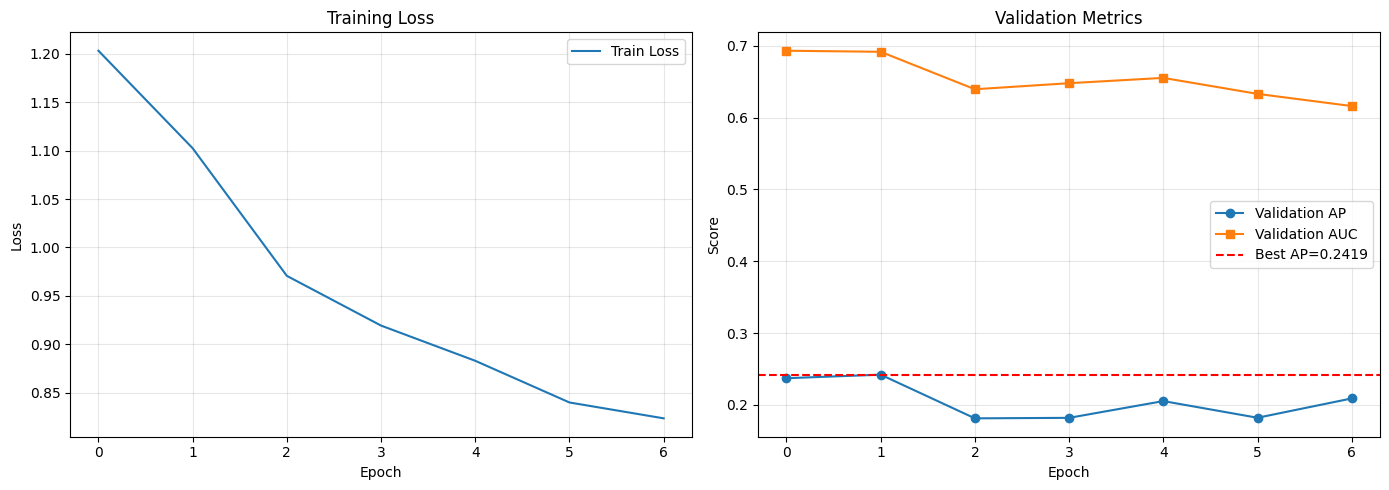

In [10]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss
ax1.plot(history["train_loss"], label="Train Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_title("Training Loss")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Metrics
ax2.plot(history["val_ap"], label="Validation AP", marker='o')
ax2.plot(history["val_auc"], label="Validation AUC", marker='s')
ax2.axhline(y=best_ap, color='r', linestyle='--', label=f'Best AP={best_ap:.4f}')
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Score")
ax2.set_title("Validation Metrics")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Save Model

In [ ]:
# Save model
model_dir = Path("../IEOR4212/exploration/processed") / MARKET_ID
model_dir.mkdir(parents=True, exist_ok=True)
model_path = model_dir / "mamba_move.pt"

torch.save({
    'model_state_dict': model.state_dict(),
    'threshold': threshold,
    'test_ap': test_ap,
    'test_auc': test_auc,
    'config': {
        'd_model': D_MODEL,
        'dropout': DROPOUT,
        'd_in': Xtr.shape[-1],
        'market_id': MARKET_ID,
    }
}, model_path)

print(f"\n✓ Model saved to: {model_path}")
print(f"  - Calibrated threshold: {threshold:.3f}")
print(f"  - Test AP: {test_ap:.4f}")
print(f"  - Test AUC: {test_auc:.4f}")